# Analyzing Time Series 
<hr style="border:2px solid black">

## 1. Introduction 

### 1.1 Time Series Data

- ordered sequence of observations at equal intervals of time
- no notion of independent and dependent variables
- observations not independent of each other
- may exhibit a variety of patterns

### 1.2 Time Series Components

- a time series may conveniently be split into several components
- each represents an underlying pattern category

>|  component  |                         pattern                                   |
 |:-----------:|:-----------------------------------------------------------------:|
 |   `Trend`   |     long-term rises and falls not having periodic pattern         |
 |`Seasonality`|recurring pattern of fixed/known period (e.g., year, quarter, week)|
 | `Remainder` |      leftover time series devoid of trend and seasonality         |

### 1.3 Decomposition Types


>|      type      |           model                 |           suitable when            |
 |:--------------:|:-------------------------------:|:----------------------------------:|
 |   `Additive`   |    $$y_t = T_t + S_t + R_t$$    | variance fairly constant over time |
 |`Multiplicative`|$$y_t = T_t\times S_t\times  R_t$$|variance changes significantly over time|

#### Load Packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# time-related stack
from datetime import datetime as dt

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

**user defined functions**

In [2]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

<hr style="border:2px solid black">

## 2. Decomposition-Type Examples

### 2.1 Additive Model

**Monthly Milk Production**

In [3]:
# https://www.kaggle.com/datasets
# /pkmisra/monthly-milk-production-pounds
milk = pd.read_csv('../data/milk_production.csv',skipfooter=1)

In [4]:
milk.columns

Index(['Month', 'Monthly milk production: pounds per cow. Jan 62 ? Dec 75'], dtype='object')

In [5]:
# rename columns
rename_dict = dict(zip(milk.columns,['month','production']))
milk.rename(columns=rename_dict,inplace=True)

In [6]:
milk.head()

,month,production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [7]:
milk.tail()

,month,production
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [8]:
# create date index
milk['date'] = milk['month'].apply(
    lambda x: dt.strptime(x,'%Y-%m')
)
milk.set_index('date', inplace=True)

# drop month column
milk.drop('month', axis=1, inplace=True)

In [9]:
# check data head
milk.head()

,production
date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [10]:
# data info
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


**data plot**

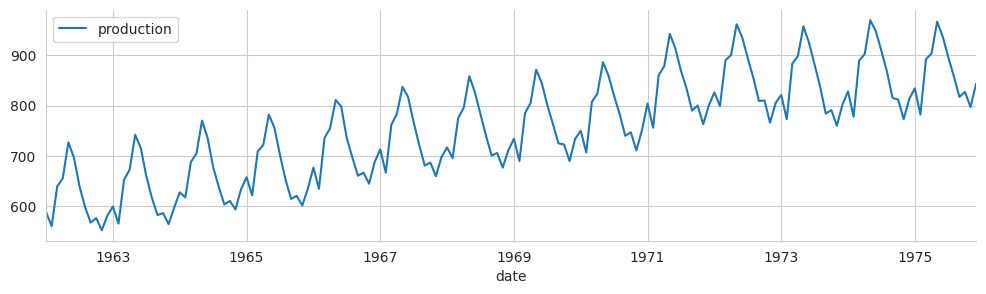

In [11]:
# milk production data plot
mpl.rc('figure',figsize=(12,3),dpi=100)

milk['production'].plot(legend=True)
sns.despine()

**dispersion of rolling variance**

In [12]:
# quartile coefficient of dispersion
qcd_variance(milk['production'])

quartile coefficient of dispersion: 0.090215


### 2.2 Multiplicative Model

**Airline Flight Passengers**

In [13]:
# load data from seaborn
flights = sns.load_dataset('flights')

In [14]:
# check columns
flights.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [15]:
# create date index
flights['date'] = flights.apply(
    lambda x: dt.strptime(str(x['year'])+str(x['month']), '%Y%b'),
    axis = 1
)
flights.set_index('date',inplace=True)

# drop year and month
flights.drop(['year','month'],axis=1,inplace=True)

In [16]:
# check data head
flights.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [17]:
# data info
flights.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


**data plot**

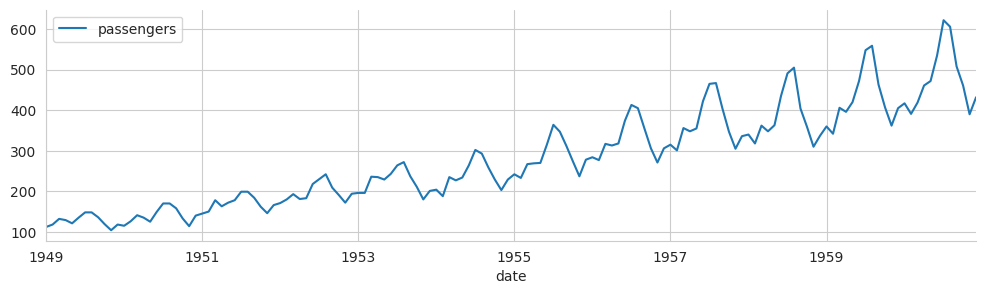

In [18]:
# alirline passenger data plot
mpl.rc('figure',figsize=(12,3),dpi=100)

flights['passengers'].plot(legend=True)
sns.despine()

**dispersion of rolling variance**

In [19]:
# quartile coefficient of dispersion
qcd_variance(flights['passengers'])

quartile coefficient of dispersion: 0.73513


### 2.3 Multiplicative$\rightarrow$Additive

[**Log Transformations**](https://numpy.org/doc/stable/reference/generated/numpy.log.html)
>- `numpy.log()`: $~~~~~$works with strictly positive values
>- `numpy.log1p()`: $~$works with non-negative values

[**Power Transformations**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
(generalizations of log transformations)
>- [`Box-Cox Transformation`](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/): $~~~~~~~~~~$works with strictly positive values
>- [`Yeo-Johnson Transformation`](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/): $~~$works with positive and negative values

**Example**

In [20]:
# log transformation
flights['transformed'] = np.log(flights['passengers'])

flights.head()

,passengers,transformed
date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


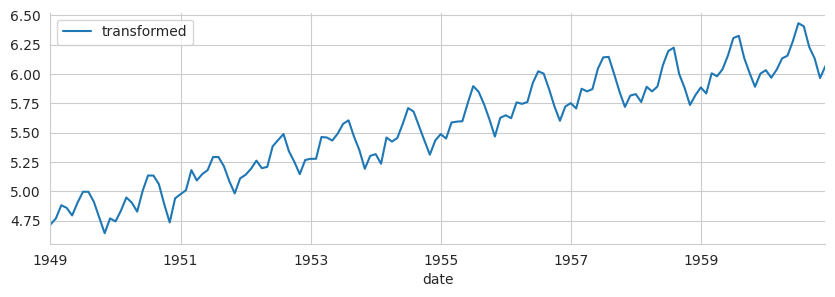

In [21]:
mpl.rc('figure',figsize=(10,3),dpi=100)

flights['transformed'].plot(legend=True)
sns.despine()

**dispersion of rolling variance**

In [22]:
# quartile coefficient of dispersion
qcd_variance(flights['transformed'])

quartile coefficient of dispersion: 0.23541


<hr style="border:2px solid black">

## 3. Time-Series Analysis: Milk Production Data

### 3.1 Train-Test Split

In [23]:
train = milk.iloc[:-12]
train.shape

(156, 1)

In [24]:
test = milk.iloc[-12:]
test.shape

(12, 1)

In [25]:
train.to_csv('../data/milk_train.csv')
test.to_csv('../data/milk_test.csv')

### 3.2 Model Trend

**feature and target**

In [26]:
# engineer timestep variable for future convenience

train['timestep'] = list(range(train.shape[0]))

In [27]:
# feature and target for trend model

X_trend = train[['timestep']]
y_trend = train['production']

**build trend model**

In [28]:
# trend model

trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [29]:
# fit model

trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

**predict from model**

In [30]:
train['trend'] = trend_model.predict(X_trend)

**plot predicted and original trends**

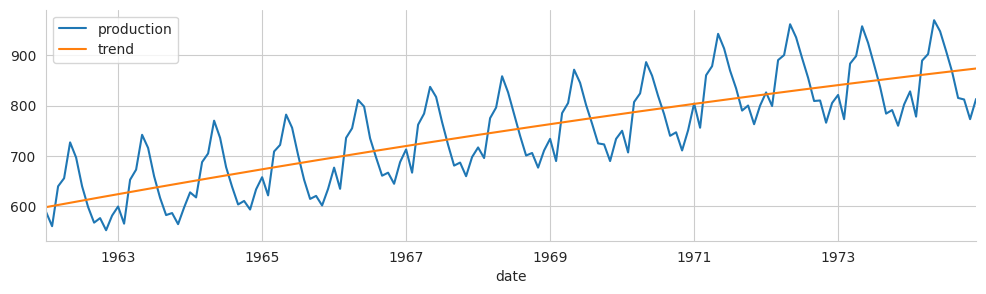

In [31]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['production','trend']].plot(legend=True)
sns.despine()

### 2.5 Model Seasonality

**detrended data**

In [32]:
train['detrended'] = train['production'] - train['trend']

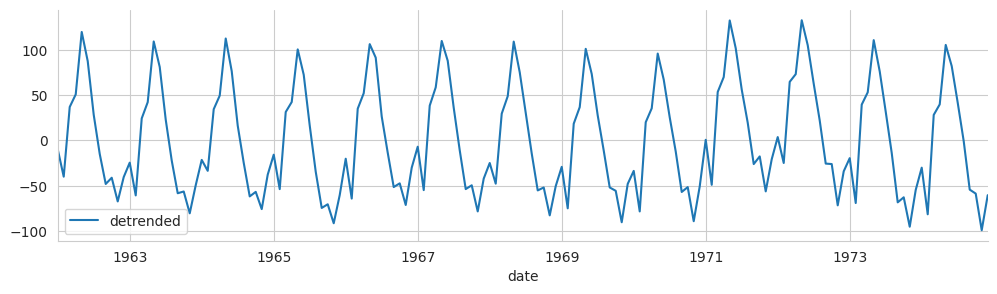

In [33]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

**feature and target**

In [34]:
# create month column

train['month'] = train.index.month

In [35]:
# feature and target for seasonality model

X_seasonality = train[['month']]
y_seasonality = train['detrended']

**build seasolanity model**

In [36]:
# seasonality model

seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [37]:
# fit model

seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

**predict from model**

In [38]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

**Plot seasonality and detrended data**

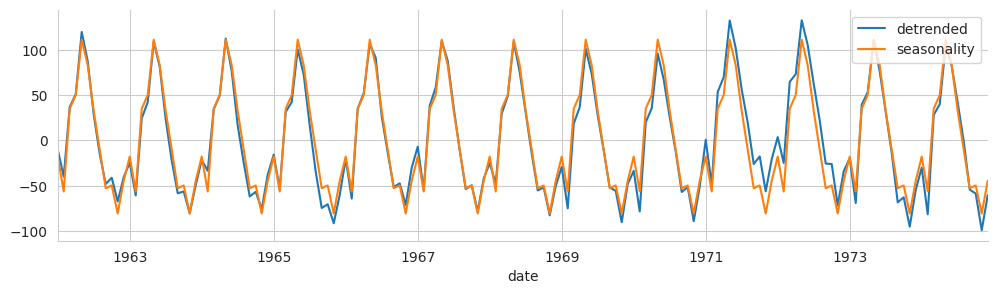

In [39]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

**Plot trend + seasonality and original data**

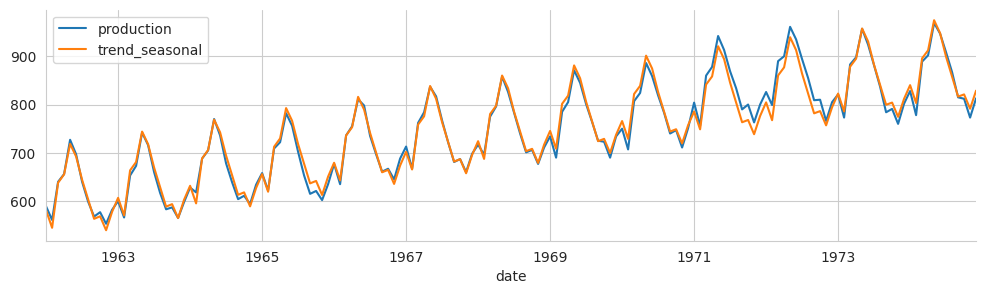

In [40]:
# combine trend and seasonality

train['trend_seasonal'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['production','trend_seasonal']].plot(legend=True)
sns.despine()

### 2.6 Extract Remainder

In [41]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['production'] - train['trend_seasonal']

**Plot remainder**

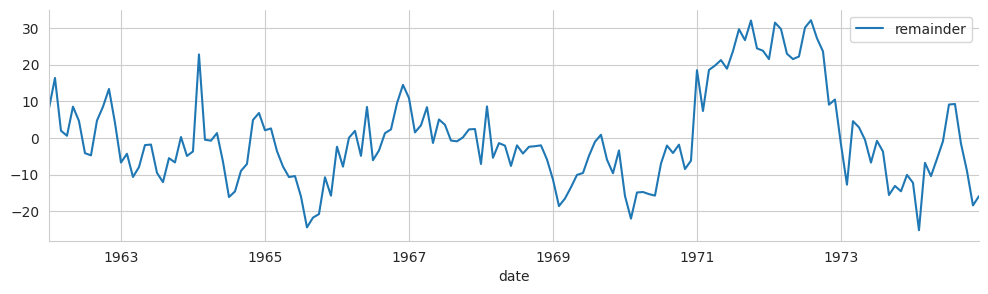

In [42]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

**check homoscedasticity**

In [43]:
# quartile coefficient of dispersion

qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.433963


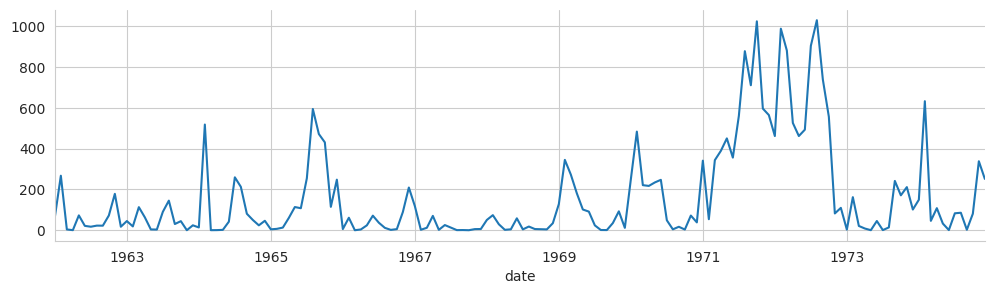

In [44]:
# volatility plot

mpl.rc('figure',figsize=(12,3),dpi=100)
(train['remainder']**2).plot()
sns.despine()

<br>

**Questions**

>- ***Is there any information stored in the remainder?***
>- ***If yes, how to extract this in order to build a better model?***

<br>

**Save reminder for further analysis**

In [45]:
milk_remainder = train['remainder'].reset_index()
milk_remainder.to_csv('../data/milk_remainder.csv',index=False)

<hr style="border:2px solid black">

## 4. Decomposition with `statsmodels`

`pip install statsmodels`

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

[`statsmodel`](https://www.statsmodels.org/stable/index.html)
- Python module for various statistical model estimation, statistical tests, and statistical data exploration

In [ ]:
sd = seasonal_decompose(train['production'], model='additive')

plt.rcParams['figure.figsize'] = (14,6)
sd.plot();

<hr style="border:2px solid black">

## References

- Forecasting: Principles and Practice, R. J. Hyndman & G. Athanasopoulos,
[OTexts Free Online Book](https://otexts.com/fpp3/)
- [Different types of Time Series Decomposition](https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693)
- [Some excellent youtube videos](https://www.youtube.com/playlist?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3)